In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import torchvision.transforms as transforms
from torchvision import models
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

# Hyperparameters


In [92]:
args = { 'random_state':42,
        'epochs':10,
        'lr': 2e-4,
        'batch_size': 32,
        'train_path': './train.csv',
        'test_path': './test.csv',
        'train_img_path': './images/train',
        'test_img_path': './images/test',
        'submission_path': './sample_submission.csv'
        }


# Data EDA

In [3]:
train_df = pd.read_csv(args['train_path'])
train_df.head()
#test_df = pd.read_csv(args['test_path'])


,id,filename,genus
0,8,401ddb5a-ba72-453e-af36-94f67c848408.jpg,Muscicapidae
1,1458,b434e45c-d3f1-42a9-907f-411375222f70.jpg,Anatidae
2,1411,feca4f5f-07c4-4b00-a3cc-748efaa97abf.jpg,Anatidae
3,723,91c2f551-5df8-4808-ba6f-e48714dc9e1d.jpg,Scolopacidae
4,4199,595d31ea-3c6c-4141-9d0a-1dbfbf0b600e.jpg,Strigidae


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4258 entries, 0 to 4257
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        4258 non-null   int64 
 1   filename  4258 non-null   object
 2   genus     4258 non-null   object
dtypes: int64(1), object(2)
memory usage: 99.9+ KB


In [5]:
print(f"number of classes: {train_df['genus'].nunique()}")
train_df.value_counts('genus')

number of classes: 27


genus
Anatidae             507
Accipitridae         322
Laridae              319
Muscicapidae         300
Fringillidae         300
Scolopacidae         268
Corvidae             248
Motacillidae         199
Picidae              192
Emberizidae          170
Paridae              167
Sylviidae            124
Turdidae             105
Acrocephalidae        97
Columbidae            94
Charadriidae          85
Falconidae            83
Ardeidae              77
Rallidae              75
Laniidae              74
Phasianidae           74
Phylloscopidae        70
Strigidae             69
Hirundinidae          67
Phalacrocoracidae     64
Alaudidae             56
Passeridae            52
Name: count, dtype: int64

In [6]:
test_df = pd.read_csv(args['test_path'])
test_df.head()

,id,filename
0,530,393ae222-30df-4382-853d-189ca54d3ce7.jpg
1,427,d5c0ea48-9f86-40bd-ab8c-4844e442d946.jpg
2,179,73909c37-cdcc-423b-aee2-a7e531e38c58.jpg
3,347,87abdfb0-ded0-4732-ac49-ba0c219265a9.jpg
4,324,483cdf8a-8b21-4bb0-a3b0-dd5c7720f92e.jpg


In [7]:
submission_df = pd.read_csv(args['submission_path'])
submission_df.head()

,id,genus
0,530,Laniidae
1,427,Phasianidae
2,179,Motacillidae
3,347,Sylviidae
4,324,Falconidae


<Axes: xlabel='count', ylabel='genus'>

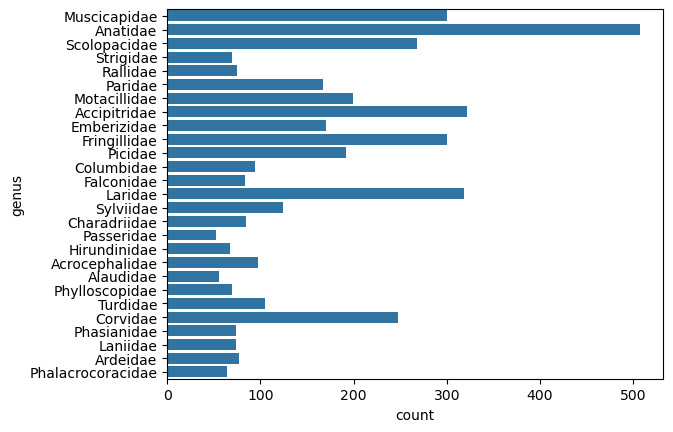

In [8]:
# check the number of classes
# data is imbalanced
sns.countplot(train_df['genus'])

(300, 300, 3)    4258
Name: count, dtype: int64

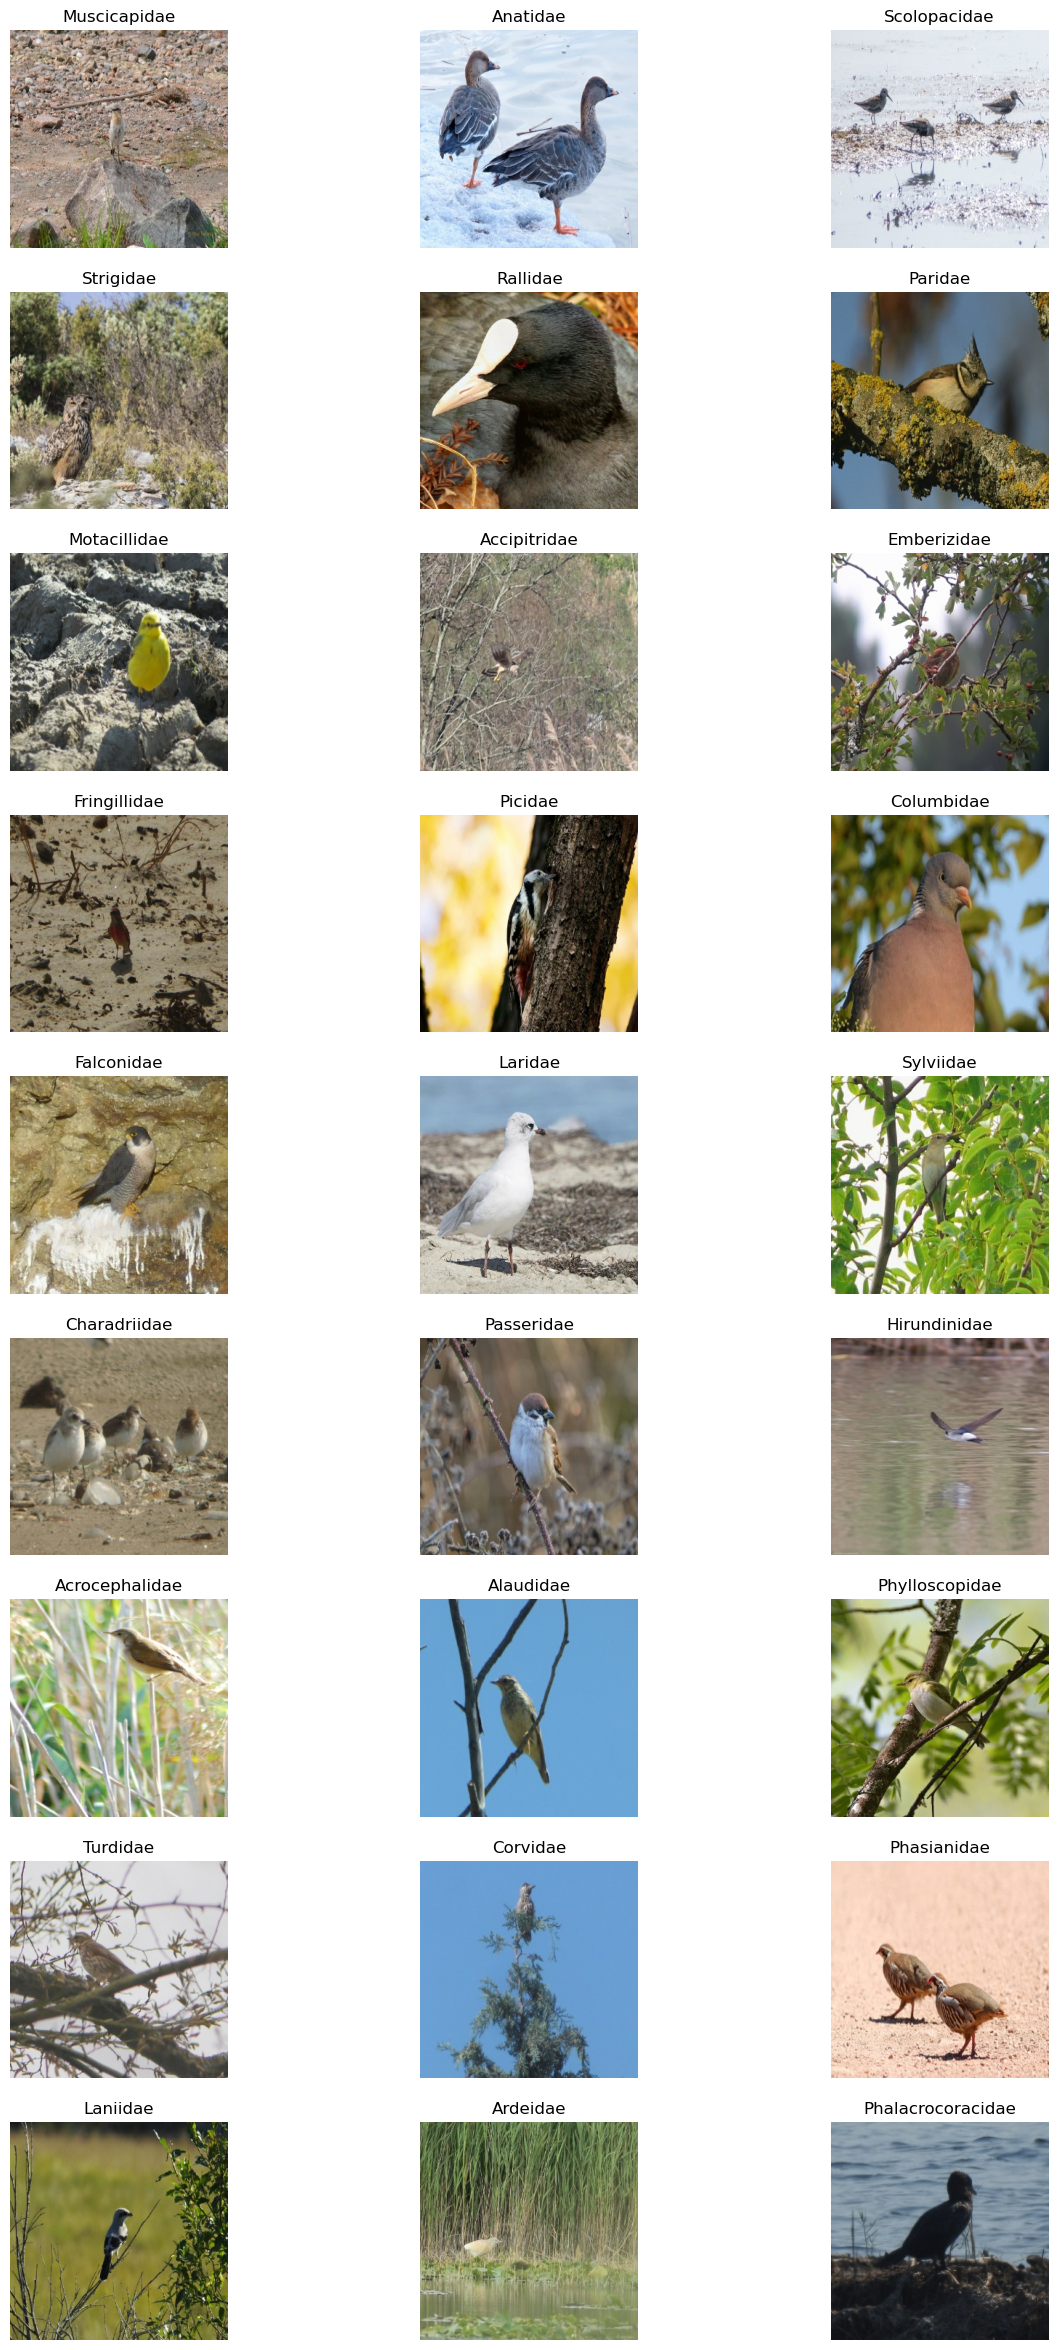

In [9]:
# check the shape of the train set image
# all images are 300 * 300 * 3(RGB)

n_classes = train_df['genus'].nunique()
n_cols = 3
n_rows = (n_classes + n_cols - 1) // n_cols

fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 30))
img_size_list = []
classes_list = []


for step in range(len(train_df)):
    img_name = train_df['filename'][step]
    img_path = os.path.join(args['train_img_path'], img_name)
    img = mpimg.imread(img_path)
    if not train_df['genus'][step] in classes_list:
        classes_list.append(train_df['genus'][step])
        row, col = (len(classes_list)-1)//n_cols, (len(classes_list)-1)%n_cols
        ax[row][col].imshow(img)
        ax[row][col].set_title(train_df['genus'][step])
        ax[row][col].axis('off')    
        
    img_size_list.append(img.shape)

pd.Series(img_size_list).value_counts()

In [10]:
# check the shape of the test set image
for step in range(len(test_df)):
    img_name = test_df['filename'][step]
    img_path = os.path.join(args['test_img_path'], img_name)
    img = mpimg.imread(img_path)
    img_size_list.append(img.shape)

pd.Series(img_size_list).value_counts()

(300, 300, 3)    4798
Name: count, dtype: int64

# Preprocessing

## target encoding

In [11]:
class Encoder():
    def __init__(self):
        self.label_encoder = LabelEncoder()
    
    # only for train set
    def fit_transform(self, label: pd.Series):
        return self.label_encoder.fit_transform(label)
    
    # for validation or test set
    def transform(self, label: pd.Series):
        # update label encoder classes for new labels
        for unique_label in label.unique():
            if unique_label not in self.label_encoder.classes_:
                self.label_encoder.classes_.append(unique_label)
        
        return self.label_encoder.transform(label)
    
    def inverse_transform(self, label: pd.Series):
        return self.label_encoder.inverse_transform(label)



In [12]:
target_encoder = Encoder()
train_df['genus'] = target_encoder.fit_transform(train_df['genus'])
target_encoder.label_encoder.classes_

array(['Accipitridae', 'Acrocephalidae', 'Alaudidae', 'Anatidae',
       'Ardeidae', 'Charadriidae', 'Columbidae', 'Corvidae',
       'Emberizidae', 'Falconidae', 'Fringillidae', 'Hirundinidae',
       'Laniidae', 'Laridae', 'Motacillidae', 'Muscicapidae', 'Paridae',
       'Passeridae', 'Phalacrocoracidae', 'Phasianidae', 'Phylloscopidae',
       'Picidae', 'Rallidae', 'Scolopacidae', 'Strigidae', 'Sylviidae',
       'Turdidae'], dtype=object)

In [13]:
train_df.head()

,id,filename,genus
0,8,401ddb5a-ba72-453e-af36-94f67c848408.jpg,15
1,1458,b434e45c-d3f1-42a9-907f-411375222f70.jpg,3
2,1411,feca4f5f-07c4-4b00-a3cc-748efaa97abf.jpg,3
3,723,91c2f551-5df8-4808-ba6f-e48714dc9e1d.jpg,23
4,4199,595d31ea-3c6c-4141-9d0a-1dbfbf0b600e.jpg,24


## Custom Dataset

In [14]:
data_transform = {
    'train': transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    
    # dataset of ImageNet mean, std
    transforms.Normalize(mean=[0.485, 0.456, 0.406]
                         , std=[0.229, 0.224, 0.225])
    ]),
    
    'test': transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    
    # dataset of ImageNet mean, std
    transforms.Normalize(mean=[0.485, 0.456, 0.406]
                         , std=[0.229, 0.224, 0.225])
    ])
}


In [36]:
class CustomDataset(Dataset):
    def __init__(self, df, img_path, transform=None, flag='train'):
        self.df = df
        self.img_path = img_path
        self.transform = transform
        self.flag = flag
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df['id'][idx]
        img_name = self.df['filename'][idx]
        img_path = os.path.join(self.img_path, img_name)
        # get label
        if self.flag == 'train':
            label = torch.tensor(self.df['genus'][idx], dtype=torch.long)
        
        # read image
        image = mpimg.imread(img_path)
        # transform
        if self.transform:
            image = self.transform(image)
            
        if self.flag == 'train':
            return (image, label)
        else:
            return (image, )


In [37]:
train_set = CustomDataset(train_df, args['train_img_path'], transform=data_transform['train'], flag='train')
test_set = CustomDataset(test_df, args['test_img_path'], transform=data_transform['test'], flag='test')
print(f"train set length: {len(train_set)}, test set length: {len(test_set)}")
print(f"train set image shape: {train_set[0][0].shape}, train set label: {train_set[0][1]}, test set image shape: {test_set[0][0].shape}")


train set length: 4258, test set length: 540
train set image shape: torch.Size([3, 64, 64]), train set label: 15, test set image shape: torch.Size([3, 64, 64])


/opt/anaconda3/envs/mldl/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [38]:
train_set, validation_set = train_test_split(train_set, test_size=0.2, random_state=args['random_state'])

In [39]:
train_loader = DataLoader(train_set, batch_size=args['batch_size'], shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=args['batch_size'], shuffle=False)
test_loader = DataLoader(test_set, batch_size=args['batch_size'], shuffle=False)

# device setting


In [19]:
torch.backends.mps.is_available()

True

In [20]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


# model definition

In [63]:
log_dir_pretrained = './logs/pre-trained'

# SummaryWriter for pre-trained model
writer_pretrained = SummaryWriter(log_dir=log_dir_pretrained)

## Pre-trained model
- VGG16 : 
- ResNet50: 

In [118]:
# reference: https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet34.html#torchvision.models.resnet34
resnet34 = models.resnet34(pretrained=True)
# https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L167
# line206 보면, __init__에서 fc라고 이미 정의를 해둠.
model_hyperparameters = {
    'input_dim': resnet34.fc.in_features,
    'output_dim': train_df['genus'].nunique()
}
resnet34.fc = nn.Linear(resnet34.fc.in_features, n_classes)
resnet34.to(device)

/opt/anaconda3/envs/mldl/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/mldl/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [119]:
optimizer = optim.Adam(resnet34.parameters(), lr=args['lr'])
loss_fn = nn.CrossEntropyLoss()

In [125]:
def train(model, train_loader, criterion, optimizer, writer, epoch):
    model.train()
    
    train_loss = 0
    corrects = 0
    # training
    for images, labels in tqdm(train_loader):
        # zero grad
        optimizer.zero_grad()
        
        # move to device
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        outputs_idx = torch.argmax(outputs, dim=1)
        
        # calculate epoch loss and accuracy
        train_loss += loss.item()
        corrects += (outputs_idx == labels).sum().item()
        
        # backward pass and update weights
        loss.backward()
        optimizer.step()
    
    train_loss /= len(train_loader)
    train_acc = corrects / len(train_loader.dataset)
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Acc/Train', train_acc, epoch)
    print(f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

In [124]:
def evaluate(model, validation_loader, criterion, writer, epoch):
    model.eval()
    
    with torch.no_grad():
        val_loss = 0
        corrects = 0
        for images, labels in tqdm(validation_loader):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            outputs_idx = torch.argmax(outputs, dim=1)
            corrects += (outputs_idx == labels).sum().item()

        val_loss /= len(validation_loader)
        val_acc = corrects / len(validation_loader.dataset)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Acc/Validation', val_acc, epoch)
        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")


In [126]:
def fitting(model, train_loader, validation_loader, criterion, optimizer, writer, num_epochs):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        train(model, train_loader, criterion, optimizer, writer, epoch)
        evaluate(model, validation_loader, criterion, writer, epoch)


In [127]:
fitting(resnet34, train_loader, validation_loader, loss_fn, optimizer, writer_pretrained, args['epochs'])

Epoch 1/10


100%|██████████| 107/107 [00:11<00:00,  9.47it/s]


 Train Loss: 1.8755, Train Acc: 0.4486


100%|██████████| 27/27 [00:00<00:00, 52.12it/s]


Validation Loss: 2.5053, Validation Acc: 0.3157
Epoch 2/10


100%|██████████| 107/107 [00:10<00:00, 10.02it/s]


 Train Loss: 1.1951, Train Acc: 0.6559


100%|██████████| 27/27 [00:00<00:00, 52.60it/s]


Validation Loss: 2.8492, Validation Acc: 0.3134
Epoch 3/10


100%|██████████| 107/107 [00:10<00:00,  9.93it/s]


 Train Loss: 0.7306, Train Acc: 0.7913


100%|██████████| 27/27 [00:00<00:00, 51.85it/s]


Validation Loss: 3.1199, Validation Acc: 0.3040
Epoch 4/10


100%|██████████| 107/107 [00:10<00:00,  9.83it/s]


 Train Loss: 0.4974, Train Acc: 0.8517


100%|██████████| 27/27 [00:00<00:00, 51.65it/s]


Validation Loss: 3.0529, Validation Acc: 0.3228
Epoch 5/10


100%|██████████| 107/107 [00:10<00:00,  9.96it/s]


 Train Loss: 0.2791, Train Acc: 0.9216


100%|██████████| 27/27 [00:00<00:00, 50.05it/s]


Validation Loss: 3.3364, Validation Acc: 0.3204
Epoch 6/10


100%|██████████| 107/107 [00:10<00:00,  9.96it/s]


 Train Loss: 0.2386, Train Acc: 0.9336


100%|██████████| 27/27 [00:00<00:00, 51.30it/s]


Validation Loss: 3.5651, Validation Acc: 0.3204
Epoch 7/10


100%|██████████| 107/107 [00:10<00:00,  9.82it/s]


 Train Loss: 0.2347, Train Acc: 0.9313


100%|██████████| 27/27 [00:00<00:00, 50.43it/s]


Validation Loss: 3.6636, Validation Acc: 0.3239
Epoch 8/10


100%|██████████| 107/107 [00:10<00:00, 10.03it/s]


 Train Loss: 0.2250, Train Acc: 0.9287


100%|██████████| 27/27 [00:00<00:00, 51.94it/s]


Validation Loss: 3.8147, Validation Acc: 0.3087
Epoch 9/10


100%|██████████| 107/107 [00:10<00:00,  9.79it/s]


 Train Loss: 0.2620, Train Acc: 0.9196


100%|██████████| 27/27 [00:00<00:00, 49.12it/s]


Validation Loss: 3.8142, Validation Acc: 0.2782
Epoch 10/10


100%|██████████| 107/107 [00:11<00:00,  9.66it/s]


 Train Loss: 0.2312, Train Acc: 0.9351


100%|██████████| 27/27 [00:00<00:00, 52.74it/s]

Validation Loss: 3.9525, Validation Acc: 0.2969


In [83]:
# Write graph of baseline
sample_input, _ = next(iter(train_loader))
sample_input = sample_input.to(device)
writer_pretrained.add_graph(resnet34, sample_input)

writer_pretrained.close()

In [130]:
!netstat -anv | grep LISTEN 

tcp4       0      0  127.0.0.1.6006         *.*                    LISTEN               0          0  131072  131072  18743      0 00000 00000006 0000000000444952 00000000 00000900      1      0 000000
tcp6       0      0  ::1.50014              *.*                    LISTEN               0          0  131072  131072  18744      0 00100 00000006 000000000044493e 00000001 00000800      1      0 000000
tcp6       0      0  *.7070                 *.*                    LISTEN               0          0  131072   12288  97320      0 00100 00000002 000000000043fdbd 00000000 00000800      1      0 000000
tcp4       0      0  *.7070                 *.*                    LISTEN               0          0  131072   12288  97320      0 00100 00000002 000000000043fdbc 00000000 00000900      1      0 000000
tcp6       0      0  *.61580                *.*                    LISTEN               0          0  131072  131072  59543      0 00100 00000006 0000000000437133 00000001 00000800      1     

In [131]:
!kill 18743

In [129]:
%load_ext tensorboard
%tensorboard --logdir logs --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
